# Module

In [25]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import optuna
from optuna.samplers import TPESampler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

# Data

In [2]:
data_path = "./data/"

train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")
submission = pd.read_csv(data_path + "sampleSubmission.csv")

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# Feature Engineering

- 01_EDA.ipynb 내용을 바탕으로 함
    - datetime에서 연도, 시간, 요일 특성을 추출
    - weather==4 데이터를 제거
    - 상관관계가 약한 windspeed 특성 제외

In [5]:
train = train[train['weather']!=4]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10885 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10885 non-null  object 
 1   season      10885 non-null  int64  
 2   holiday     10885 non-null  int64  
 3   workingday  10885 non-null  int64  
 4   weather     10885 non-null  int64  
 5   temp        10885 non-null  float64
 6   atemp       10885 non-null  float64
 7   humidity    10885 non-null  int64  
 8   windspeed   10885 non-null  float64
 9   casual      10885 non-null  int64  
 10  registered  10885 non-null  int64  
 11  count       10885 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


- 1개 데이터 제거됨(10,886 -> 10,885)

In [6]:
all_data = pd.concat([train, test], ignore_index=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [7]:
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0]) # 날짜
all_data['year'] = all_data['date'].apply(lambda x: x.split('-')[0]) # 연도
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시간
all_data['weekday'] = all_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,04,5


In [8]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed']
all_data = all_data.drop(drop_features, axis=1)

all_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5


In [9]:
x_train = all_data[~pd.isnull(all_data['count'])]
x_test = all_data[pd.isnull(all_data['count'])]

x_train = x_train.drop(['count'], axis=1)
x_test = x_test.drop(['count'], axis=1)

y = train['count']

x_train.shape, x_test.shape, y.shape

((10885, 10), (6493, 10), (10885,))

In [10]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [11]:
log_y = np.log(y)

# Model

## Linear

In [12]:
linear_reg = LinearRegression()
linear_reg.fit(x_train, log_y)

LinearRegression()

In [13]:
preds = np.exp(linear_reg.predict(x_train))
rmsle = mean_squared_log_error(y, preds, squared=False)
print(f'RMSLE of Linear Model : {rmsle:.4f}')

RMSLE of Linear Model : 1.0205


## Ridge

In [18]:
def objective_ridge(trial: optuna.trial.Trial):
    params = {
        'alpha':trial.suggest_float('alpha', 1e-2, 1000.0, log=True),
        'max_iter':trial.suggest_int('max_iter', 1000, 5000, step=1000)
    }

    ridge = Ridge(**params, random_state=2025)
    ridge.fit(x_train, log_y)
    preds = np.exp(ridge.predict(x_train))
    rmsle = mean_squared_log_error(y, preds, squared=False)

    return rmsle

sampler = TPESampler(seed=2025)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective_ridge, n_trials=50)

print(f'Total Trials : {len(study.trials)}')
print(f'Best Trial : {study.best_trial.number}')
print(f'Best RMSLE of Ridge : {study.best_value:.4f}')
print('Best Parameters of Ridge')
for key, value in study.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-13 07:06:14,632] A new study created in memory with name: no-name-ad143474-a683-4907-a870-e0b55039ee44
[I 2025-11-13 07:06:14,653] Trial 0 finished with value: 1.0204980007529392 and parameters: {'alpha': 0.04758179465292095, 'max_iter': 5000}. Best is trial 0 with value: 1.0204980007529392.
[I 2025-11-13 07:06:14,678] Trial 1 finished with value: 1.0208560178229769 and parameters: {'alpha': 460.28645974410426, 'max_iter': 3000}. Best is trial 0 with value: 1.0204980007529392.
[I 2025-11-13 07:06:14,703] Trial 2 finished with value: 1.0204976879666912 and parameters: {'alpha': 0.8733286960935058, 'max_iter': 2000}. Best is trial 2 with value: 1.0204976879666912.
[I 2025-11-13 07:06:14,728] Trial 3 finished with value: 1.0204919709636797 and parameters: {'alpha': 19.356994530951457, 'max_iter': 3000}. Best is trial 3 with value: 1.0204919709636797.
[I 2025-11-13 07:06:14,753] Trial 4 finished with value: 1.021223749333255 and parameters: {'alpha': 662.5094787455846, 'max_iter

Total Trials : 50
Best Trial : 10
Best RMSLE of Ridge : 1.0205
Best Parameters of Ridge
alpha : 58.862006781579076
max_iter : 1000


In [19]:
study.best_params

{'alpha': 58.862006781579076, 'max_iter': 1000}

- Linear Model에 비해 성능 개선 없음

## Lasso

In [20]:
def objective_lasso(trial: optuna.trial.Trial):
    params = {
        'alpha':trial.suggest_float('alpha', 1e-2, 1000.0, log=True),
        'max_iter':trial.suggest_int('max_iter', 1000, 5000, step=1000)
    }

    lasso = Lasso(**params, random_state=2025)
    lasso.fit(x_train, log_y)
    preds = np.exp(lasso.predict(x_train))
    rmsle = mean_squared_log_error(y, preds, squared=False)

    return rmsle

sampler = TPESampler(seed=2025)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective_lasso, n_trials=50)

print(f'Total Trials : {len(study.trials)}')
print(f'Best Trial : {study.best_trial.number}')
print(f'Best RMSLE of Lasso : {study.best_value:.4f}')
print('Best Parameters of Lasso')
for key, value in study.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-13 07:06:31,464] A new study created in memory with name: no-name-3c8ec409-28cf-4880-94d4-36d479048383
[I 2025-11-13 07:06:31,506] Trial 0 finished with value: 1.0251452412430344 and parameters: {'alpha': 0.04758179465292095, 'max_iter': 5000}. Best is trial 0 with value: 1.0251452412430344.
[I 2025-11-13 07:06:31,560] Trial 1 finished with value: 1.4197281003549047 and parameters: {'alpha': 460.28645974410426, 'max_iter': 3000}. Best is trial 0 with value: 1.0251452412430344.
[I 2025-11-13 07:06:31,624] Trial 2 finished with value: 1.0657103428886314 and parameters: {'alpha': 0.8733286960935058, 'max_iter': 2000}. Best is trial 0 with value: 1.0251452412430344.
[I 2025-11-13 07:06:31,657] Trial 3 finished with value: 1.4197281003549047 and parameters: {'alpha': 19.356994530951457, 'max_iter': 3000}. Best is trial 0 with value: 1.0251452412430344.
[I 2025-11-13 07:06:31,685] Trial 4 finished with value: 1.4197281003549047 and parameters: {'alpha': 662.5094787455846, 'max_ite

Total Trials : 50
Best Trial : 13
Best RMSLE of Lasso : 1.0206
Best Parameters of Lasso
alpha : 0.010061740845167
max_iter : 4000


- Linear Model에 비해 성능 개선 없음

## RandomForest

In [21]:
def objective_rf(trial: optuna.trial.Trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 50, 200, step=10)
    }

    model = RandomForestRegressor(**params, random_state=2025)
    model.fit(x_train, log_y)
    preds = np.exp(model.predict(x_train))
    rmsle = mean_squared_log_error(y, preds, squared=False)

    return rmsle

sampler = TPESampler(seed=2025)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective_rf, n_trials=50)

print(f'Total Trials : {len(study.trials)}')
print(f'Best Trial : {study.best_trial.number}')
print(f'Best RMSLE of RandomForest : {study.best_value:.4f}')
print('Best Parameters of RandomForest')
for key, value in study.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-13 07:07:49,219] A new study created in memory with name: no-name-762a4f3e-4006-48b3-87a1-3cadc2c036fa
[I 2025-11-13 07:07:51,485] Trial 0 finished with value: 0.11480873942543439 and parameters: {'n_estimators': 70}. Best is trial 0 with value: 0.11480873942543439.
[I 2025-11-13 07:07:57,520] Trial 1 finished with value: 0.11235661120030133 and parameters: {'n_estimators': 190}. Best is trial 1 with value: 0.11235661120030133.
[I 2025-11-13 07:08:03,582] Trial 2 finished with value: 0.11235661120030133 and parameters: {'n_estimators': 190}. Best is trial 1 with value: 0.11235661120030133.
[I 2025-11-13 07:08:07,436] Trial 3 finished with value: 0.1131280116382348 and parameters: {'n_estimators': 120}. Best is trial 1 with value: 0.11235661120030133.
[I 2025-11-13 07:08:10,939] Trial 4 finished with value: 0.11338156409633433 and parameters: {'n_estimators': 110}. Best is trial 1 with value: 0.11235661120030133.
[I 2025-11-13 07:08:13,884] Trial 5 finished with value: 0.1139

Total Trials : 50
Best Trial : 8
Best RMSLE of RandomForest : 0.1123
Best Parameters of RandomForest
n_estimators : 200


In [24]:
best_params = study.best_params
rf_model = RandomForestRegressor(**best_params, random_state=2025)
rf_model.fit(x_train, log_y)

preds_train = np.exp(rf_model.predict(x_train))
preds_test = np.exp(rf_model.predict(x_test))

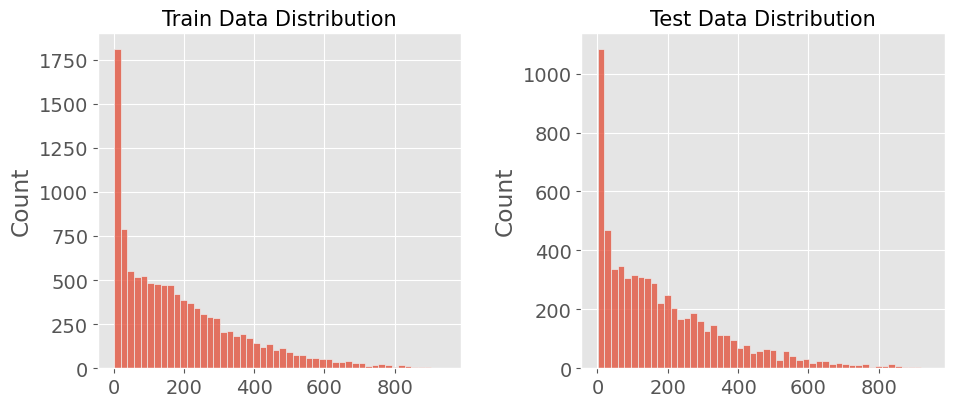

In [27]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
fig, axes = plt.subplots(ncols=2)
plt.tight_layout()
fig.set_size_inches(10, 4)

sns.histplot(preds_train, bins=50, ax=axes[0])
axes[0].set(title="Train Data Distribution")
sns.histplot(preds_test, bins=50, ax=axes[1])
axes[1].set(title="Test Data Distribution")
plt.show()

# Submission

In [28]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [29]:
submission['count'] = preds_test
submission.head()

,datetime,count
0,2011-01-20 00:00:00,11.147081
1,2011-01-20 01:00:00,4.674041
2,2011-01-20 02:00:00,2.760867
3,2011-01-20 03:00:00,3.579780
4,2011-01-20 04:00:00,2.759032


In [30]:
submission.to_csv(data_path + "submission.csv", index=False)

In [ ]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c bike-sharing-demand -f "./data/submission.csv" -m "RandomForest"

100%|█████████████████████████████████████████| 244k/244k [00:00<00:00, 561kB/s]
Successfully submitted to Bike Sharing Demand

- Private Score : 0.39578